In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import gzip
import copy
import pickle as pk
iport heapq as hp

import networkx as nx
from networkx.algorithms import bipartite, components, shortest_paths

# Importing the datasets, cleaning, transforming

## Import

**Instacart datasets** (provided) : https://www.instacart.com/datasets/grocery-shopping-2017 . The instacart datasets consist in a group of 5 different datasets, each adopting a different point of view 
* "products", a dataset based on the product point of view, describing to which aisle and department it belongs to
* "aisles", a dataset that enriches "products" by describing each aisle formally
* "departments", a dataset that enriches "products" by describing each department formally
* "orders", a dataset based on the order point of view, describing when it was purchased
* "order_products_prior", a dataset based on both the order and product point of view, associating each order with the products that were purchased

After loading the datasets, we verify whether there are any missing values. 

In [2]:
products = pd.read_csv('data/products.csv', sep=',')
products.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [3]:
products.isnull().values.any()

False

In [4]:
aisles = pd.read_csv('data/aisles.csv', sep=',')
aisles.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [5]:
aisles.isnull().values.any()

False

In [6]:
aisles.size

268

In [7]:
departments = pd.read_csv('data/departments.csv', sep=',')
departments.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [8]:
departments.isnull().values.any()

False

In [9]:
print(departments.size)
departments.head(50)

42


,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol
5,6,international
6,7,beverages
7,8,pets
8,9,dry goods pasta
9,10,bulk


In [10]:
orders = pd.read_csv('data/orders.csv', sep=',')
orders.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [11]:
orders.isnull().values.sum()==orders['days_since_prior_order'].isnull().values.sum()

True

In [12]:
orders.size

23947581

The missing values in _orders_ appear to correspond to the date of "previous order", when it happens to be the first one.

In [13]:
history = pd.read_csv('data/order_products__prior.csv', sep=',')
history.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1.0,1.0
1,2,28985,2.0,1.0
2,2,9327,3.0,0.0
3,2,45918,4.0,1.0
4,2,30035,5.0,0.0


In [14]:
history.isnull().values.any()

True

There are no unexpected NaN values in any of the Instacart datasets.

## Gathering all datasets

**Create a dataset with all useful information gathered : products_litteral**

We first add the names of the aisle and department in the _products_ dataset, instead of the ID, by merging the datasets :

In [15]:
products_litteral = pd.merge(pd.merge(products, aisles, on='aisle_id'), departments, on='department_id').drop(['aisle_id', 'department_id'], axis=1)
products_litteral.head()

,product_id,product_name,aisle,department
0,1,Chocolate Sandwich Cookies,cookies cakes,snacks
1,78,Nutter Butter Cookie Bites Go-Pak,cookies cakes,snacks
2,102,Danish Butter Cookies,cookies cakes,snacks
3,172,Gluten Free All Natural Chocolate Chip Cookies,cookies cakes,snacks
4,285,Mini Nilla Wafers Munch Pack,cookies cakes,snacks


In [16]:
products_litteral.to_pickle('products_litteral.pk')

In [5]:
products_litteral = pd.read_pickle('products_litteral.pk')

In [16]:
nb_prods_per_dept = products_litteral.groupby('department').count().sort_values(by='product_id')
nb_prods_per_dept.head(50)

,product_id,product_name,aisle
department,,,
bulk,38,38,38
other,548,548,548
meat seafood,907,907,907
pets,972,972,972
alcohol,1054,1054,1054
babies,1081,1081,1081
breakfast,1115,1115,1115
international,1139,1139,1139
missing,1258,1258,1258


**Dealing with 'missing' values**


In [17]:
missing = products_litteral[(products_litteral.department =='missing') | (products_litteral.aisle=='missing')]
missing.head(20)

,product_id,product_name,aisle,department
42813,38,Ultra Antibacterial Dish Liquid,missing,missing
42814,72,Organic Honeycrisp Apples,missing,missing
42815,110,Uncured Turkey Bologna,missing,missing
42816,297,"Write Bros Ball Point Pens, Cap-Pen, Medium (1...",missing,missing
42817,417,Classics Baby Binks Easter Chocolate Bunny,missing,missing
42818,437,Strawberry Cheesecake Nonfat Yogurt,missing,missing
42819,440,Crossovers Olive Thyme Almond,missing,missing
42820,472,Fancy Diced Hot Chilies,missing,missing
42821,491,Pompelmo Water,missing,missing
42822,556,Bake & Break Cheese Garlic Loaf,missing,missing


We can see many products don't have any name for the aisle and/or department

In [18]:
print("There are %d products with 'missing' aisle/department. This represent %0.1f%% of the products." %(missing.shape[0], missing.shape[0]/products_litteral.shape[0]*100))

There are 1258 products with 'missing' aisle/department. This represent 2.5% of the products.


The unlabelled products seem to come from many different categories, and represent a small fraction of our dataset. We decide in a first approach to let them in our work dataset, but to treat them carefully. In further steps, we may remove them or find a way to associate them with their correct aisle and department.

In [19]:
#products_litteral = products_litteral.drop(missing.index)

In [16]:
del(products)
#del(missing)

### Start graphs

In [24]:
orders_products = pd.merge(orders, history, on='order_id').drop(['add_to_cart_order', 'reordered'], axis=1)

KeyboardInterrupt: 

In [ ]:
orders_products.to_pickle('orders_products.pk')

In [17]:
orders_products = pd.read_pickle('orders_products.pk')

In [18]:
food_depts = ['bulk', 'meat seafood', 'snacks', 'beverages', 'frozen', 'dairy eggs', 'canned goods', 'dry goods pasta', 'produce', 'bakery', 'deli', 'breakfast', 'alcohol', 'pantry', 'international']

In [19]:
food_aisles = {row.aisle for i, row in products_litteral.iterrows() if row.department in food_depts}

In [21]:
with open('food_aisles.pk', 'wb') as file:
    pk.dump(food_aisles, file)

In [2]:
# Here
with open('food_aisles.pk', 'rb') as file:
    food_aisles = pk.load(file)

In [7]:
by_aisle = {}
for aisle in food_aisles:
    by_aisle[aisle] = products_litteral[products_litteral.aisle==aisle]
    by_aisle[aisle].to_pickle('by_aisle_'+aisle+'.pk')

In [3]:
# Here
by_aisle = {}
for aisle in food_aisles:
    by_aisle[aisle] = pd.read_pickle('by_aisle_'+aisle+'.pk')

In [8]:
del(products_litteral)

In [32]:
orders_products_by_aisle = {}
for aisle in food_aisles:
    orders_products_by_aisle[aisle] = pd.merge(orders_products, by_aisle[aisle], on='product_id')[['user_id', 'product_id', 'order_id', 'product_name']]
    #print(orders_products_by_aisle[aisle].head())

In [ ]:
orders_users_by_aisle = {}
for aisle in food_aisles:
    orders_users_by_aisle[aisle] = orders_products_by_aisle[aisle].groupby(['user_id', 'product_id', 'product_name']).count().rename(columns={'order_id':'nb_orders'})
    orders_users_by_aisle[aisle].to_pickle('orders_users_by_aisle_'+aisle+'.pk')
    print(orders_users_by_aisle[aisle].head())

In [22]:
orders_users_by_aisle = {}
for aisle in food_aisles:
    orders_users_by_aisle[aisle] = pd.read_pickle('orders_users_by_aisle_'+aisle+'.pk')
    print(orders_users_by_aisle[aisle].head())

                                                                     nb_orders
user_id product_id product_name                                               
14      15134      Strawberry Gelatin                                        1
95      13368      Organic Cooked Vanilla Pudding & Pie Filling Mix          1
117     17627      Butterscotch Pudding                                      1
152     4357       Organic Chocolate Almondmilk Pudding                      1
154     40443      Tapioca Pudding Snacks                                    1
                                            nb_orders
user_id product_id product_name                      
2       8138       Traditional Hummus               1
        32139      Hommus Classic Original          3
        33276      Kalamata Olive Spread            2
        49451      Artichoke Spinach Dip            1
10      30489      Original Hummus                  3
                                                   nb_orders
user_id 

In [23]:
tot_user_by_aisle = {}
for aisle in food_aisles:
    orders_users_by_aisle[aisle] = orders_users_by_aisle[aisle].reset_index()
    # print(orders_users_by_aisle[aisle].head())
    tot_user_by_aisle[aisle] = orders_users_by_aisle[aisle][['user_id', 'nb_orders']].groupby('user_id').sum().rename(columns={'nb_orders':'tot_orders'})
    print(tot_user_by_aisle[aisle].head())

         tot_orders
user_id            
14                1
95                1
117               1
152               1
154               1
         tot_orders
user_id            
2                 7
10                4
12                1
18                1
19                1
         tot_orders
user_id            
4                 1
87                1
116               1
310               2
314               1
         tot_orders
user_id            
2                 2
10                4
17                3
19                3
32                1
         tot_orders
user_id            
12                1
13                4
19                1
21                2
26                1
         tot_orders
user_id            
14                1
42                3
56                2
107               1
114               1
         tot_orders
user_id            
14                2
16                1
19                4
31                3
32                2
         tot_orders


In [42]:
tot_user = pd.concat(tot_user_by_aisle[aisle] for aisle in food_aisles).groupby('user_id').sum()
tot_user.head()

,tot_orders
user_id,
1,18
2,96
3,35
4,9
5,12


In [43]:
tot_user.to_pickle('tot_user.pk')

In [24]:
tot_user = pd.read_pickle('tot_user.pk')

In [25]:
tot_user.head()

,tot_orders
user_id,
1,18
2,96
3,35
4,9
5,12


In [41]:
tot_user.replace(0, np.nan)
tot_user.columns = ['nb_orders']
orders_users_norm_by_aisle = {}
for aisle in food_aisles:
    # print(orders_users_by_aisle[aisle].head())
    #orders_users_by_aisle[aisle] = orders_users_by_aisle[aisle].set_index(['user_id', 'product_id'])
    orders_users_norm_by_aisle[aisle] = orders_users_by_aisle[aisle][['nb_orders']] / tot_user # make sure user is index
    orders_users_norm_by_aisle[aisle].to_pickle('orders_users_norm_by_aisle_'+aisle+'.pk')

In [4]:
# Here
orders_users_norm_by_aisle = {}
for aisle in food_aisles:
    orders_users_norm_by_aisle[aisle] = pd.read_pickle('orders_users_norm_by_aisle_'+aisle+'.pk')

In [ ]:
del(orders_products_by_aisle)

In [11]:
orders_users_norm_by_aisle['honeys syrups nectars'].head()

nb_orders
user_id product_id           
27      44669        0.005450
54      3793         0.003484
        18471        0.003484
        49424        0.010453
61      31020        0.050000

In [30]:
orders_users_norm_by_aisle['yogurt'].sum()

nb_orders    8063.808511
dtype: float64

In [6]:
# start here
graphs = {aisle: nx.Graph() for aisle in food_aisles}
for aisle in food_aisles:
    for prod in by_aisle[aisle]['product_id'].unique():
        graphs[aisle].add_node(prod, bipartite=0)
    for user in orders_users_norm_by_aisle[aisle].reset_index().user_id.unique():
        graphs[aisle].add_node(-user, bipartite=1)


In [7]:
for aisle in food_aisles:
    for (user, prod), row in orders_users_norm_by_aisle[aisle].iterrows():
        graphs[aisle].add_edge(prod, -user, weight=row['nb_orders'])
    nx.write_gpickle(graphs[aisle], "users_and_prods_graph_"+aisle+'.gpk')
    print('Done', aisle)

Done packaged produce
Done tofu meat alternatives
Done fresh pasta
Done doughs gelatins bake mixes
Done nuts seeds dried fruit
Done meat counter
Done bread
Done frozen breakfast
Done milk
Done seafood counter
Done energy granola bars
Done coffee
Done packaged meat
Done bulk dried fruits vegetables
Done dry pasta
Done tea
Done instant foods
Done preserved dips spreads
Done frozen meals
Done other creams cheeses
Done bulk grains rice dried goods
Done marinades meat preparation
Done hot cereal pancake mixes
Done canned meat seafood
Done salad dressing toppings
Done specialty wines champagnes
Done fresh herbs
Done trail mix snack mix
Done granola
Done fruit vegetable snacks
Done spreads
Done breakfast bars pastries
Done prepared soups salads
Done butter
Done oils vinegars
Done buns rolls
Done crackers
Done fresh fruits
Done chips pretzels
Done cookies cakes
Done specialty cheeses
Done poultry counter
Done bakery desserts
Done grains rice dried goods
Done soy lactosefree
Done hot dogs bacon

In [ ]:
graphs = {}
for aisle in food_aisles:
    graphs[aisle] = nx.read_gpickle("users_and_prods_graph_"+aisle+'.gpk')
    print('Loaded', aisle)

dept = 'produce'
graphs[dept] = nx.Graph()
for prod in by_dept[dept]['product_id'].unique():
    graphs[dept].add_node(prod, bipartite=0)
for user in orders.user_id.unique():
    graphs[dept].add_node(-user, bipartite=1)
for (user, prod, name), row in orders_users_by_dept[dept].iterrows():
    graphs[dept].add_edge(prod, -user, weight=row['nb_orders'])

with open('user_and_prod_graphs.pk', 'rb') as file:
    graphs = pk.load(file)

In [8]:
nx.info(graphs['fresh vegetables'])

'Name: \nType: Graph\nNumber of nodes: 135846\nNumber of edges: 843336\nAverage degree:  12.4161'

In [9]:
del(graphs)

In [10]:
# project on products
def my_weight(G, u, v):
    w = 0
    n = 0
    for nbr in set(G[u]) & set(G[v]):
        n += 1
        w += (G[u][nbr].get('weight', 1) + G[v][nbr].get('weight', 1)) / 2
    return w * n

In [11]:
prod_graphs = {}
for aisle in food_aisles:
    #print('\n', dept)
    G = nx.read_gpickle("users_and_prods_graph_"+aisle+'.gpk')
    prod_graphs[aisle] = bipartite.generic_weighted_projected_graph(G, {n for n, d in G.nodes(data=True) if d['bipartite']==0}, weight_function=my_weight)
    nx.write_gpickle(G, 'prod_graphs_'+aisle+'.gpk')
    print('Done', aisle)
    #print(nx.info(prod_graphs[dept]))

Done packaged produce
Done tofu meat alternatives
Done fresh pasta
Done doughs gelatins bake mixes
Done nuts seeds dried fruit
Done meat counter
Done bread
Done frozen breakfast
Done milk
Done seafood counter
Done energy granola bars
Done coffee
Done packaged meat
Done bulk dried fruits vegetables
Done dry pasta
Done tea
Done instant foods
Done preserved dips spreads
Done frozen meals
Done other creams cheeses
Done bulk grains rice dried goods
Done marinades meat preparation
Done hot cereal pancake mixes
Done canned meat seafood
Done salad dressing toppings
Done specialty wines champagnes
Done fresh herbs
Done trail mix snack mix
Done granola
Done fruit vegetable snacks
Done spreads
Done breakfast bars pastries
Done prepared soups salads
Done butter
Done oils vinegars
Done buns rolls
Done crackers
Done fresh fruits
Done chips pretzels
Done cookies cakes
Done specialty cheeses
Done poultry counter
Done bakery desserts
Done grains rice dried goods
Done soy lactosefree
Done hot dogs bacon

In [12]:
del(prod_graphs)


 specialty cheeses


/Users/ariane/applications/miniconda3/envs/ada/lib/python3.6/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):



 nuts seeds dried fruit


ArpackNoConvergence: ARPACK error -1: No convergence (5821 iterations, 0/3 eigenvectors converged)

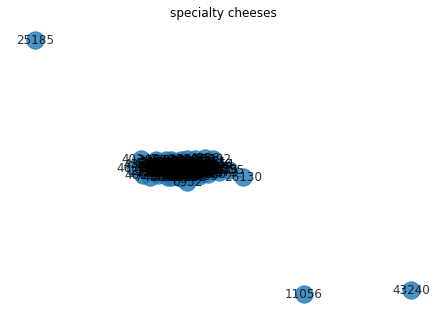

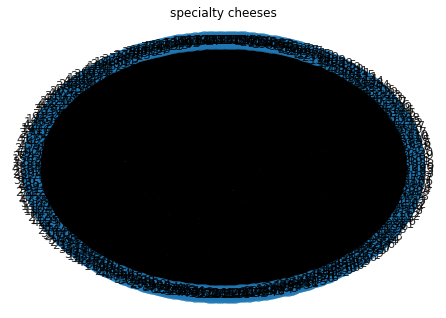

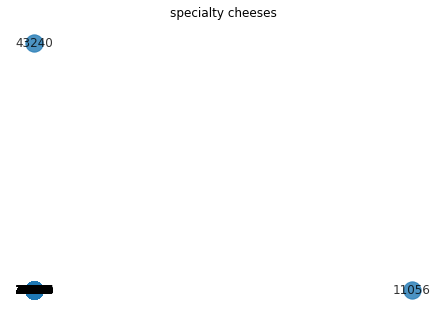

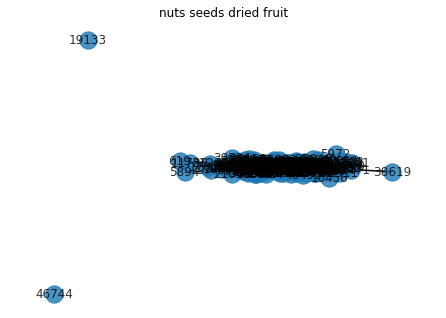

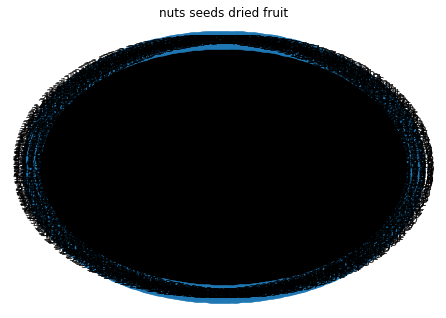

<Figure size 432x288 with 0 Axes>

In [43]:
# just have a look
c=0
for aisle in food_aisles:
    c+=1
    if c>3:
        break
    print('\n', aisle)
    #plt.figure()
    #nx.draw_spring(prod_graphs[dept], with_labels=True,  alpha = 0.8)
    #plt.title(dept)
    plt.figure()
    nx.draw(prod_graphs[aisle], with_labels=True,  alpha = 0.8)
    plt.title(aisle)
    plt.figure()
    nx.draw_circular(prod_graphs[aisle], with_labels=True,  alpha = 0.8)
    plt.title(aisle)
    plt.figure()
    nx.draw_spectral(prod_graphs[aisle], with_labels=True,  alpha = 0.8)
    plt.title(aisle)


In [75]:
spc = make_final_graph(prod_graphs["yogurt"], threshold_quantile=.3)

None
Lost products: 16 of 1026
Avg shortest Path: 1.8894935677908722
Avg weighted shortest Path: 0.02055234090705616


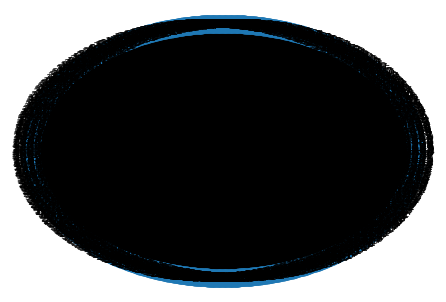

In [76]:
nx.draw_circular(spc, with_labels=True,  alpha = 0.8)

for dept in food_depts:
    lst = sorted(components.connected_components(prod_graphs[dept]), key=len, reverse=True)
    print(dept, ':')
    for g in lst[1:]:
        for p in g:
            print(by_dept[dept][by_dept[dept].product_id==p]['product_name'])
    print('\n')

dept = 'bulk'
edges = [(u, v, d['weight']) for (u, v, d) in prod_graphs[dept].edges(data=True)]
#np.mean([(u, v) for (u, v, d) in prod_graphs[dept].edges(data=True) if d['weight'] > 0.5])
edges_test = set()
for (u,v,w) in edges:
    if (v,u) in edges_test:
        print('double')
        break
    else:
        edges_test.add((u,v))

In [61]:
def look_at_edges(G):
    edge_weights = [d['weight'] for (u, v, d) in G.edges(data=True)] # if d['weight'] < 200
    plt.hist(edge_weights, bins=100, log=True)
    print(np.quantile(edge_weights, [0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.7, 0.9, 0.99]))

[1.000000e+00 1.500000e+00 2.000000e+00 4.000000e+00 7.000000e+00
 1.500000e+01 8.100000e+01 1.428200e+03 7.558396e+04]


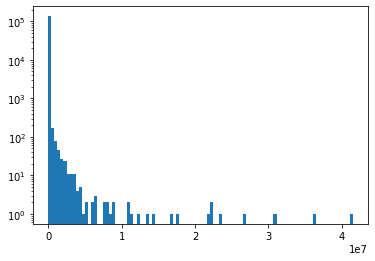

In [63]:
look_at_edges(prod_graphs["yogurt"])

array([1.913e+03, 3.550e+02, 3.080e+02, 1.440e+02, 1.410e+02, 8.700e+01,
       6.900e+01, 1.060e+02, 4.800e+01, 5.100e+01, 4.700e+01, 2.700e+01,
       2.200e+01, 3.500e+01, 2.600e+01, 1.800e+01, 1.700e+01, 3.000e+01,
       1.900e+01, 2.700e+01, 1.400e+01, 1.900e+01, 1.700e+01, 2.100e+01,
       9.000e+00, 1.100e+01, 1.900e+01, 9.000e+00, 2.100e+01, 1.400e+01,
       1.000e+00, 1.000e+01, 7.000e+00, 4.000e+00, 8.000e+00, 1.000e+01,
       9.000e+00, 3.000e+00, 3.000e+00, 4.000e+00, 7.000e+00, 0.000e+00,
       8.000e+00, 8.000e+00, 1.000e+00, 6.000e+00, 1.100e+01, 6.000e+00,
       8.000e+00, 5.000e+00, 5.000e+00, 2.000e+00, 1.100e+01, 1.000e+00,
       5.000e+00, 2.000e+00, 8.000e+00, 1.000e+00, 6.000e+00, 4.000e+00,
       2.000e+00, 4.000e+00, 3.000e+00, 3.000e+00, 2.000e+00, 7.000e+00,
       5.000e+00, 1.000e+00, 5.000e+00, 1.000e+00, 5.000e+00, 0.000e+00,
       8.000e+00, 2.000e+00, 5.000e+00, 2.000e+00, 1.000e+00, 2.000e+00,
       0.000e+00, 3.000e+00, 2.000e+00, 3.000e+00, 

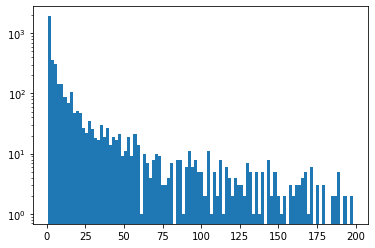

In [58]:
plt.hist(edge_weights, bins=100, log=True)[0]

In [18]:
def make_final_graph(G, aisle='None', threshold_quantile=0.3, verbose=False,save=False):
    print(aisle)
    #thresholded = nx.Graph(((u, v, d) for (u, v, d) in G.edges(data=True) if d['weight'] >= 10))
    #print('Avg shortest Path:', shortest_paths.generic.average_shortest_path_length(thresholded))
    edge_weights = [d['weight'] for (u, v, d) in G.edges(data=True)]
    lost = len(G)
    threshold_quantile = 2 * threshold_quantile
    while lost > 0.15 * len(G):
        threshold_quantile = threshold_quantile / 2
        threshold = np.quantile(edge_weights, threshold_quantile)
        thresholded_inv_edges = []
        for (u, v, d) in G.edges(data=True):
            if d['weight'] > threshold:
                nd = d.copy()
                nd['weight'] = 1. / d['weight']
                thresholded_inv_edges.append((u,v,nd))
        thresholded_inv = nx.Graph(thresholded_inv_edges)
        lost = len(G)-len(thresholded_inv)
    print('Lost products: {} of {}'.format(len(G)-len(thresholded_inv), len(G)))
    print("Used quantile: {}".format(threshold_quantile))
    #print(nx.info(thresholded_inv))
    if verbose:
        print('Avg shortest Path:', shortest_paths.generic.average_shortest_path_length(thresholded_inv))
        print('Avg weighted shortest Path:', shortest_paths.generic.average_shortest_path_length(thresholded_inv, weight='weight'))
    if save:
        nx.write_gpickle(thresholded_inv, 'thresholded_inv_'+aisle+'.gpk')
    return thresholded_inv
    
    #print(nx.info(prod_graphs[dept]))
    #print(nx.info(thresholded))

[len(c) for c in sorted(components.connected_components(thresholded), key=len, reverse=True)]

In [19]:
for aisle in food_aisles:
    make_final_graph(nx.read_gpickle('prod_graphs_'+aisle+'.gpk'), aisle, save=True)
    print('Done', aisle)
    print()

packaged produce
Lost products: 3012 of 31594
Used quantile: 0.075
Done packaged produce

tofu meat alternatives
Lost products: 1686 of 18746
Used quantile: 0.15
Done tofu meat alternatives

fresh pasta
Lost products: 1072 of 8689
Used quantile: 0.15
Done fresh pasta

doughs gelatins bake mixes
Lost products: 2227 of 22948
Used quantile: 0.15
Done doughs gelatins bake mixes

nuts seeds dried fruit
Lost products: 3513 of 51447
Used quantile: 0.15
Done nuts seeds dried fruit

meat counter
Lost products: 1832 of 16029
Used quantile: 0.15
Done meat counter

bread
Lost products: 11314 of 77606
Used quantile: 0.3
Done bread

frozen breakfast
Lost products: 2881 of 34763
Used quantile: 0.15
Done frozen breakfast

milk
Lost products: 12689 of 86148
Used quantile: 0.3
Done milk

seafood counter
Lost products: 1011 of 7623
Used quantile: 0.15
Done seafood counter

energy granola bars
Lost products: 6559 of 45856
Used quantile: 0.3
Done energy granola bars

coffee
Lost products: 2752 of 32191
Use

Lost products: 453 of 4394
Used quantile: 0.15
Done white wines

fresh dips tapenades
Lost products: 4283 of 56939
Used quantile: 0.15
Done fresh dips tapenades

soft drinks
Lost products: 4201 of 45384
Used quantile: 0.15
Done soft drinks

ice cream toppings
Lost products: 476 of 3516
Used quantile: 0.15
Done ice cream toppings

frozen vegan vegetarian
Lost products: 1590 of 15824
Used quantile: 0.15
Done frozen vegan vegetarian



Find which are target products

In [ ]:
with open('prod_healthiness_per_aisle.pk', 'rb') as f:
    healthiness_df = pk.load(f)
#healthiness = {}
#for aisle in food_aisles:
#    healthiness[aisle] = healthiness_df.to_dict('index')

healthiness = healthiness_df.to_dict('index')

In [ ]:
# to be checked
# not to run?
for aisle in food_aisles:
    G = nx.read_gpickle('thresholded_inv_'+aisle+'.gpk')
    healthiness_this_aisle = pd.merge(healthiness_df, by_aisle[aisle], on='product_id')
    print(healthiness_this_aisle.head())
    healthiness = {}
    for prod, row in healthiness_this_aisle.iterrows():
        healthiness[prod] = row.health
    nx.set_node_attributes(G, healthiness, 'healthiness')
    nx.write_gpickle(G, 'thresholded_inv_with_hscore_'+aisle+'.gpk')

In [ ]:
def find_recommendation_path(source_id, G=None, aisle=None, health_thresh=1.5, hscores=None, fscores=None, alpha=.3, beta=.2):
    if G is None:
        G = nx.read_gpickle('thresholded_inv_'+aisle+'.gpk')
    if hscores is None:
        hscores = pd.read_pickle('prod_healthiness.pk')
    targets = {x for x in G.nodes() if hscores.at[x, "healthiness"] >= health_thresh}
    G_ok = G.subgraph({x for x in G.nodes() if hscores.at[x, "healthiness"] >= hscores.at[source_id, "healthiness"]})
    pred, dist = nx.dijkstra_predecessor_and_distance(G_ok, source_id, weight='weight')
    candidates = [(0, None)]
    for candidate in targets:
        if - dist[candidate] > candidates[0][0]:   # ie candidate is closer than all current candidates
            if len(candidates) >= 10:
                hp.heappop(candidates)
            hp.heappush(candidates, (- dist[candidate], candidate))
    if fscores is None:
        fscores = pd.read_pickle('fidelity_scores.pk')
    rec = (0, None)
    fids = []
    dists = []
    healths = []
    for (mdist, candidate) in candidates:
        fids.append(scores.at[candidate, 'appreciation_per_user'])
        dists.append(- mdist)
        healths.append()
    max_fid = max(fids)
    min_fid = min(fids)
    max_dist = max(dists)
    min_dist = min(dists)
    max_health = max(healths)
    min_health = min(healths)
    for (mdist, candidate) in candidates:
        fid = (fscores.at[candidate, 'appreciation_per_user'] - min_fid) / (max_fid - min_fid)
        dist = (max_dist + mdist) / (max_dist - min_dist)
        health = (hscores.at[candidate, "healthiness"] - min_health) / (max_health - min_health)
        score = health**alpha * fid**beta * dist**(1-alpha-beta)
        if score > rec[0]:
            rec = (score, candidate)
    orig = rec[1]
    path = [orig]
    while orig != source_id:
        orig = pred[orig]
        path.append(orig)
    return path

In [ ]:
scores = pd.read_pickle('fidelity_scores.pk')


sp = shortest_paths.dense.floyd_warshall(thresholded)
sp2 = {(u,v): d for u, sp_d in sp.items() for v, d in sp_d.items()}
#print(max(sp.values()), min(sp.values()))

In [172]:
sp = shortest_paths.dense.floyd_warshall(thresholded_inv)
sp2 = {(u,v): d for u, sp_d in sp.items() for v, d in sp_d.items()}
sp2

{(47489, 47489): 0,
 (47489, 40397): 0.005401713433452273,
 (47489, 42134): 0.006066459185822916,
 (47489, 10915): 0.005596017712275927,
 (47489, 5161): 0.005230869367873795,
 (47489, 22827): 0.005480069932254269,
 (47489, 10540): 0.008978657944204983,
 (47489, 42091): 0.007912639384925499,
 (47489, 6194): 0.0058744860171745655,
 (47489, 22260): 0.00494970663339455,
 (47489, 25859): 0.09951177352608012,
 (47489, 14985): 0.034682817723384926,
 (47489, 1000): 0.005682844463306574,
 (47489, 6455): 0.022490415368248563,
 (47489, 48778): 0.026228895646164194,
 (47489, 7314): 0.005223182302148628,
 (47489, 43210): 0.0053818734403199685,
 (47489, 28067): 0.017988628444869516,
 (47489, 39653): 0.00756862063778917,
 (47489, 45682): 0.007142640947298458,
 (47489, 11325): 0.015170430178403487,
 (47489, 23038): 0.00756862063778917,
 (47489, 14611): 0.028519932672946134,
 (47489, 14665): 0.07340996215597029,
 (47489, 12699): 0.0200700136876117,
 (47489, 10224): 0.05368550680487053,
 (47489, 43769):

In [203]:
thresholded_higher = nx.Graph(((bulk_map[u], bulk_map[v], d) for (u, v, d) in prod_graphs[dept].edges(data=True) if d['weight'] >= 30))

In [204]:
print(nx.info(prod_graphs[dept]))
print(nx.info(thresholded_higher))

Name: 
Type: Graph
Number of nodes: 38
Number of edges: 326
Average degree:  17.1579
Name: 
Type: Graph
Number of nodes: 28
Number of edges: 105
Average degree:   7.5000


In [205]:
[len(c) for c in sorted(components.connected_components(thresholded_higher), key=len, reverse=True)]

[28]

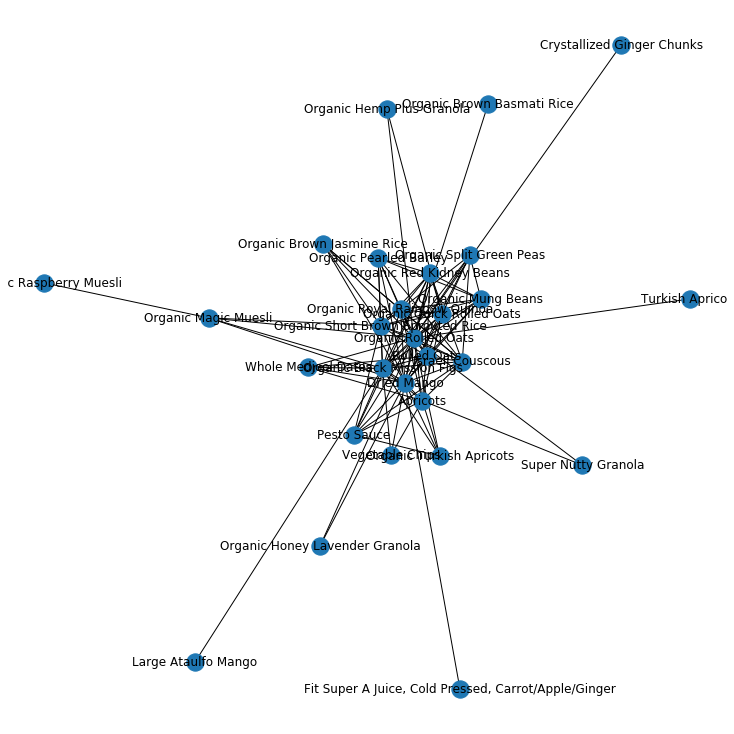

In [207]:
plt.figure(figsize=(10,10))
nx.draw(thresholded_higher, with_labels=True)

In [209]:
for node in thresholded:
    if bulk_map[node] not in thresholded_higher:
        print(bulk_map[node])
print()
for node in prod_graphs[dept]:
    if bulk_map[node] not in thresholded_higher:
        print(bulk_map[node])

Cranberry Beans
Organic White Popcorn
Organic Hunza Golden Raisins
Organic Blueberries Package
Wild Rice Blend

Cranberry Beans
Organic Emmer Farro
Organic Blueberries Package
Madagascar Pink Rice
Organic White Popcorn
Naturally Sweet Plantain Chips
Organic Roasted Buckwheat (Kasha)
Organic Hunza Golden Raisins
Wild Rice Blend
Organic Wheat Bran


In [191]:
by_dept['bulk']

,product_id,product_name,aisle,department
49650,503,Wild Rice Blend,bulk grains rice dried goods,bulk
49651,6194,Organic Red Kidney Beans,bulk grains rice dried goods,bulk
49652,6455,Organic Magic Muesli,bulk grains rice dried goods,bulk
49653,7314,Organic Quick Rolled Oats,bulk grains rice dried goods,bulk
49654,10915,Organic Short Brown Sprouted Rice,bulk grains rice dried goods,bulk
49655,11325,Organic Hemp Plus Granola,bulk grains rice dried goods,bulk
49656,12699,Super Nutty Granola,bulk grains rice dried goods,bulk
49657,14985,Organic Raspberry Muesli,bulk grains rice dried goods,bulk
49658,19066,Organic Wheat Bran,bulk grains rice dried goods,bulk
49659,22260,Organic Rolled Oats,bulk grains rice dried goods,bulk


In [194]:
bulk_map = {}
for index, row in by_dept['bulk'].iterrows():
    bulk_map[row.product_id] = row.product_name

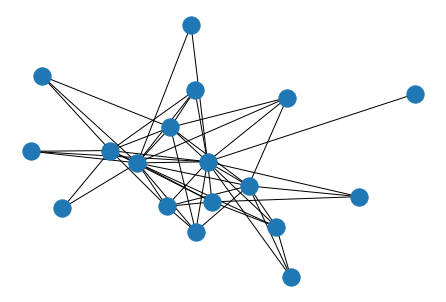

In [188]:
nx.draw_spring(thresholded_higher)

In [189]:
shortest_paths.generic.average_shortest_path_length(thresholded_higher)

1.7058823529411764

In [116]:
sp = shortest_paths.dense.floyd_warshall(thresholded_higher)
sp2 = {(u,v): d for u, sp_d in sp.items() for v, d in sp_d.items()}
#print(max(sp.values()), min(sp.values()))

{(47489, 47489): 0,
 (47489, 40397): 34.45302614079072,
 (47489, 42134): 30.00657780874821,
 (47489, 10915): 42.0,
 (47489, 5161): 42.0,
 (47489, 22827): 21.166010488516726,
 (47489, 10540): 11.0,
 (47489, 42091): 19.918584287042087,
 (47489, 6194): 19.00657780874821,
 (47489, 22260): 64.57763793828883,
 (47489, 25859): 52.60660171779821,
 (47489, 14985): 54.37490770683399,
 (47489, 1000): 39.65247584249853,
 (47489, 6455): 41.00657780874821,
 (47489, 48778): 89.62352359916264,
 (47489, 7314): 29.0,
 (47489, 43210): 37.856406460551014,
 (47489, 28067): 39.0,
 (47489, 39653): 36.68909411829051,
 (47489, 45682): 48.0,
 (47489, 11325): 33.14871343247916,
 (47489, 23038): 22.31370849898476,
 (47489, 14611): 24.0,
 (47489, 14665): 44.85582021366571,
 (47489, 12699): 36.17011495953578,
 (47489, 10224): 51.00657780874821,
 (47489, 43769): 48.98746799453936,
 (47489, 30365): 45.89934640057524,
 (47489, 46889): 48.856406460551014,
 (47489, 19628): 52.0,
 (47489, 38613): 54.99038105676658,
 (474

In [167]:
thresholded_inv_edges = []
for (u, v, d) in prod_graphs[dept].edges(data=True):
    if d['weight'] >= 10:
        nd = d.copy()
        nd['weight'] = 1. / d['weight']
        thresholded_inv_edges.append((u,v,nd))
thresholded_inv = nx.Graph(thresholded_inv_edges)
print(nx.info(thresholded_inv))

Name: 
Type: Graph
Number of nodes: 33
Number of edges: 164
Average degree:   9.9394


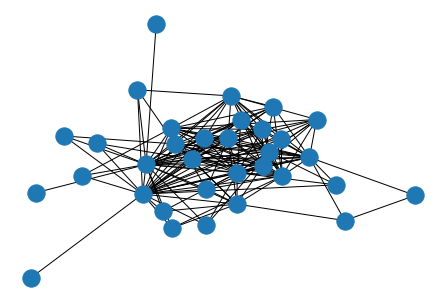

In [169]:
nx.draw_spring(thresholded_inv)

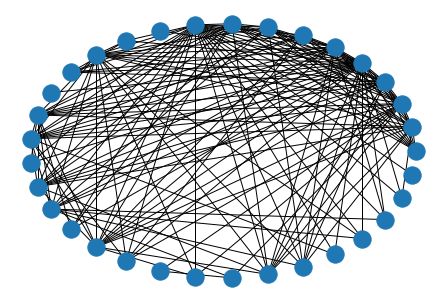

In [170]:
nx.draw_circular(thresholded_inv)

In [174]:
shortest_paths.generic.average_shortest_path_length(thresholded_inv, weight='weight')

0.032407449099350484

In [172]:
sp = shortest_paths.dense.floyd_warshall(thresholded_inv)
sp2 = {(u,v): d for u, sp_d in sp.items() for v, d in sp_d.items()}
sp2

{(47489, 47489): 0,
 (47489, 40397): 0.005401713433452273,
 (47489, 42134): 0.006066459185822916,
 (47489, 10915): 0.005596017712275927,
 (47489, 5161): 0.005230869367873795,
 (47489, 22827): 0.005480069932254269,
 (47489, 10540): 0.008978657944204983,
 (47489, 42091): 0.007912639384925499,
 (47489, 6194): 0.0058744860171745655,
 (47489, 22260): 0.00494970663339455,
 (47489, 25859): 0.09951177352608012,
 (47489, 14985): 0.034682817723384926,
 (47489, 1000): 0.005682844463306574,
 (47489, 6455): 0.022490415368248563,
 (47489, 48778): 0.026228895646164194,
 (47489, 7314): 0.005223182302148628,
 (47489, 43210): 0.0053818734403199685,
 (47489, 28067): 0.017988628444869516,
 (47489, 39653): 0.00756862063778917,
 (47489, 45682): 0.007142640947298458,
 (47489, 11325): 0.015170430178403487,
 (47489, 23038): 0.00756862063778917,
 (47489, 14611): 0.028519932672946134,
 (47489, 14665): 0.07340996215597029,
 (47489, 12699): 0.0200700136876117,
 (47489, 10224): 0.05368550680487053,
 (47489, 43769):

In [210]:
products_litteral[products_litteral.aisle == 'packaged produce'].head(50)

,product_id,product_name,aisle,department


In [177]:
products_litteral[products_litteral.aisle == 'packaged vegetables fruits'].head(50)

,product_id,product_name,aisle,department
41129,31,White Pearl Onions,packaged vegetables fruits,produce
41130,43,Organic Clementines,packaged vegetables fruits,produce
41131,66,European Style Spring Mix,packaged vegetables fruits,produce
41132,89,Yogurt Fruit Dip Sliced Apples,packaged vegetables fruits,produce
41133,120,Cauliflower Florettes,packaged vegetables fruits,produce
41134,142,Arugula Salad,packaged vegetables fruits,produce
41135,343,Organic Whole Peeled Baby Carrots,packaged vegetables fruits,produce
41136,347,"Vegetable Salad Kit, Sweet Kale",packaged vegetables fruits,produce
41137,364,Greener Selection Salad,packaged vegetables fruits,produce
41138,380,Clementine Bag,packaged vegetables fruits,produce


In [16]:
nb_prods_per_dept = products_litteral.groupby('department').count().sort_values(by='product_id')
nb_prods_per_dept.head(50)

,product_id,product_name,aisle
department,,,
bulk,38,38,38
other,548,548,548
meat seafood,907,907,907
pets,972,972,972
alcohol,1054,1054,1054
babies,1081,1081,1081
breakfast,1115,1115,1115
international,1139,1139,1139
missing,1258,1258,1258
